<a href="https://colab.research.google.com/github/bosla67/Colab/blob/main/BuildingAssetTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building an Asset Trading Strategy**
https://www.kaggle.com/code/shtrausslearning/building-an-asset-trading-strategy/notebook

In [1]:
!pip install catboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [ ]:
# download data file
# ! wget https://transfer.sh/uWWDfzcAIY/data22.csv
# ! wget https://transfer.sh/U7TjAuGP2W/data22_2_1.csv

# !wget https://oshi.at/mNZE
# ! pwd
# ! ls -la

In [2]:
!wget https://github.com/bosla67/Colab/raw/refs/heads/main/Data/EURUSD/2015/EURUSD_OSC_6m.zip -O EURUSD_OSC_6m.zip
!unzip ./EURUSD_OSC_6m.zip -d ./Data
!rm ./EURUSD_OSC_6m.zip


--2025-02-25 18:08:08--  https://github.com/bosla67/Colab/raw/refs/heads/main/Data/EURUSD/2015/EURUSD_OSC_6m.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bosla67/Colab/refs/heads/main/Data/EURUSD/2015/EURUSD_OSC_6m.zip [following]
--2025-02-25 18:08:08--  https://raw.githubusercontent.com/bosla67/Colab/refs/heads/main/Data/EURUSD/2015/EURUSD_OSC_6m.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23613706 (23M) [application/zip]
Saving to: ‘EURUSD_OSC_6m.zip’

EURUSD_OSC_6m.zip   100%[===================>]  22.52M  --.-KB/s    in 0.07s   

2025-02-25 18:08:09 (327 MB/s) - ‘EURUSD_OSC_6

In [5]:
header_file_location = './Data/EURUSD_head.csv'
signal_file_location = './Data/EURUSD_0_signal.bin'
label_file_location = './Data/EURUSD__0_label.bin'

In [6]:
# Header processing
with open(header_file_location, 'r') as file:
    content = file.readlines()

meta = dict()
meta['columns'] = content[0].strip().split('\t')
meta.update(dict( [(param, int(val)) for param, val in [l.strip().split('\t') for l in content[1:]]]))
print('Columns\t',meta['cntColumns'])
print('Sequence\t', meta['lenSequence'])
print('Records\t', meta['cntRecords'])


Columns	 90
Sequence	 20
Records	 140658


In [67]:
# meta['columns'][39]='rsi2_M1'
# meta['columns'][39]

'rsi2_M1'

In [66]:
meta['columns']

['ama_m_diff_H4_D1',
 'ama_m_diff_H1_H4',
 'ama_m_diff_M15_H1',
 'ama_m_diff_M5_M15',
 'ama_m_diff_M1_M5',
 'ch_ama_m_H4',
 'ch_ama_m_H1',
 'ch_ama_m_M15',
 'ch_ama_m_M5',
 'ch_ama_m_M1',
 'diff_ama_hm_H4',
 'diff_ama_hm_H1',
 'diff_ama_hm_M15',
 'diff_ama_hm_M5',
 'diff_ama_hm_M1',
 'diff_ama_lm_H4',
 'diff_ama_lm_H1',
 'diff_ama_lm_M15',
 'diff_ama_lm_M5',
 'diff_ama_lm_M1',
 'diff_tema_hm_H4',
 'diff_tema_hm_H1',
 'diff_tema_hm_M15',
 'diff_tema_hm_M5',
 'diff_tema_hm_M1',
 'diff_tema_lm_H4',
 'diff_tema_lm_H1',
 'diff_tema_lm_M15',
 'diff_tema_lm_M5',
 'diff_tema_lm_M1',
 'rsi0_H4',
 'rsi0_H1',
 'rsi0_M15',
 'rsi0_M5',
 'rsi0_M1',
 'rsi2_H4',
 'rsi2_H1',
 'rsi2_M15',
 'rsi2_M5',
 'rsi2_M1',
 'rsi1_H4',
 'rsi1_H1',
 'rsi1_M15',
 'rsi1_M5',
 'rsi1_M1',
 'mom0_H4',
 'mom0_H1',
 'mom0_M15',
 'mom0_M5',
 'mom0_M1',
 'mom1_H4',
 'mom1_H1',
 'mom1_M15',
 'mom1_M5',
 'mom1_M1',
 'mom2_H4',
 'mom2_H1',
 'mom2_M15',
 'mom2_M5',
 'mom2_M1',
 'stc_d0_H4',
 'stc_k0_H4',
 'stc_d0_H1',
 'stc_k0_H

In [8]:
import pandas as pd
import numpy as np
import struct

In [118]:
#############################################################
# define a np.dtype that matches our binary record layout
# labels file
dt_label=np.dtype([
    ('date_time', '<f8'),
    ('signal', '<i1'),
    ('label', '<i1')
])

with open(label_file_location, 'rb') as f:
    bin = f.read()

np_data_l = np.frombuffer(bin, dtype=dt_label)
f_labels = pd.DataFrame(np_data_l)
f_labels.index = pd.to_datetime(f_labels.date_time, unit='s')
f_labels.drop('date_time', axis=1, inplace=True)
print(f_labels.label.value_counts())
#
f_labels

label
 1    67636
-1    65964
 0     7058
Name: count, dtype: int64


,signal,label
date_time,,
2015-01-07 12:00:26.802000046,12,1
2015-01-07 12:00:28.628999949,21,1
2015-01-07 12:00:51.471999884,31,-1
2015-01-07 12:01:00.665999889,12,-1
2015-01-07 12:01:01.665999889,13,-1
...,...,...
2015-07-03 23:45:18.555999994,31,-1
2015-07-03 23:46:51.520999907,42,1
2015-07-03 23:46:56.085999966,31,1


In [119]:
# define a np.dtype that matches our binary record layout
# signal file
dt_signal = np.dtype(f"f8, i1, ({meta['cntColumns']}, {meta['lenSequence']} )i2")

with open(signal_file_location, 'rb') as f:
    bin = f.read()

np_data_s = np.frombuffer(bin, dtype=dt_signal)

# Load first two columns ('f0' and 'f1') into a pandas DataFrame
f_signals = pd.DataFrame(np_data_s[['f0', 'f1']])
f_signals.index = pd.to_datetime(f_signals.f0, unit='s')
f_signals.drop('f0', axis=1, inplace=True)

# Remove first two columns from the ndarray
np_data_s = np_data_s['f2']  # Keep only the 'f2' column in the ndarray

In [120]:
(len(f_signals), len(f_labels))

(140661, 140658)

In [92]:
# Шукаєм та видаляєм розбіжності
f_signals.index.difference(f_labels.index)

DatetimeIndex(['2015-07-03 23:50:15', '2015-07-03 23:50:42',
               '2015-07-03 23:50:59'],
              dtype='datetime64[ns]', freq=None)

In [93]:
f_signals[-5:]

,f1
f0,
2015-07-03 23:46:56.739000082,11
2015-07-03 23:48:12.000000000,42
2015-07-03 23:50:15.000000000,43
2015-07-03 23:50:42.000000000,23
2015-07-03 23:50:59.000000000,33


In [121]:
# Remove last 3 elements (as not labeled)
f_signals=f_signals[:-3]
print("f_signals len = ", len(f_signals))

np_data_s=np_data_s[:-3]
print("np_data_s len = ", len(np_data_s))
np_data_s.shape


f_signals len =  140658
np_data_s len =  140658


(140658, 90, 20)

Після виконаної перевірки ми маєм датафрейми однакового розміру і з однаковими індексами а також відповідний їм numpy ndarray (140658, 90, 20)



In [122]:
# добавим данні з numpy ndarray в df
for colName in meta['columns']:
    f_labels[colName] = np_data_s[:, meta['columns'].index(colName),-2] # передостанній
    # f_labels[colName] = np_data_s[:, meta['columns'].index(colName),-1]   # останній єлемент з послідовності

f_labels.head()

,signal,label,ama_m_diff_H4_D1,ama_m_diff_H1_H4,ama_m_diff_M15_H1,ama_m_diff_M5_M15,ama_m_diff_M1_M5,ch_ama_m_H4,ch_ama_m_H1,ch_ama_m_M15,...,stc_d2_H4,stc_k2_H4,stc_d2_H1,stc_k2_H1,stc_d2_M15,stc_k2_M15,stc_d2_M5,stc_k2_M5,stc_d2_M1,stc_k2_M1
date_time,,,,,,,,,,,,,,,,,,,,,
2015-01-07 12:00:26.802000046,12,1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:00:28.628999949,21,1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:00:51.471999884,31,-1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:01:00.665999889,12,-1,-2671,-62,-256,-59,-72,-71,-14,-4,...,15,13,24,23,26,16,11,8,18,22
2015-01-07 12:01:01.665999889,13,-1,-2671,-62,-256,-59,-72,-71,-14,-4,...,15,13,24,23,26,16,11,8,18,22


In [96]:
f_labels.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140658 entries, 2015-01-07 12:00:26.802000046 to 2015-07-03 23:48:12
Data columns (total 92 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   signal             140658 non-null  int8 
 1   label              140658 non-null  int8 
 2   ama_m_diff_H4_D1   140658 non-null  int16
 3   ama_m_diff_H1_H4   140658 non-null  int16
 4   ama_m_diff_M15_H1  140658 non-null  int16
 5   ama_m_diff_M5_M15  140658 non-null  int16
 6   ama_m_diff_M1_M5   140658 non-null  int16
 7   ch_ama_m_H4        140658 non-null  int16
 8   ch_ama_m_H1        140658 non-null  int16
 9   ch_ama_m_M15       140658 non-null  int16
 10  ch_ama_m_M5        140658 non-null  int16
 11  ch_ama_m_M1        140658 non-null  int16
 12  diff_ama_hm_H4     140658 non-null  int16
 13  diff_ama_hm_H1     140658 non-null  int16
 14  diff_ama_hm_M15    140658 non-null  int16
 15  diff_ama_hm_M5     140658 non-null  int16

In [123]:
len(f_labels)

140658

In [124]:
# підготуєм df для тренування
df = f_labels.iloc[:10000]

In [ ]:
# f_signals[['mom0_H4','mom0_H1','mom0_M15','mom0_M5','mom0_M1']].describe()
# f_signals[['mom0_H4','mom0_H1','mom0_M15','mom0_M5','mom0_M1', 'mom1_H4','mom1_H1','mom1_M15','mom1_M5','mom1_M1', 'mom2_H4','mom2_H1','mom2_M15','mom2_M5','mom2_M1']][:20]
# # f_signals.describe()


In [99]:
import os
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
import shap

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# time series cross validation
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

''' FUNCTIONS '''

# One plot type
def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):

    # sec_id - list of [False,False,True] values of when to activate supblots; same length as lst

    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()

    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

# plot n verticle subplots
def plot_vsubplots(ldf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):

    # lw_id list of line widths if added

    assert(nplots is not None)
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines',name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1)

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):

    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0,
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')

    if(ret_id):
        return corr

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None,
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None,
             figsize = (10,4),axis_grid = 'y'):

    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

# function to plot a two PCA Feature Plot using Pandas
def scatterPlot(xDF, yDF, algoName):

    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()


# reduce memory (@mfjwr1); distorts the data a little (but reduces by 60% memory)
def red_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Split for TimeSeries
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):

    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')

        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]

        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')

    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:]
    else:
        print('Choose One Splitting Method Only')

#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]

    return train_df,pred_df # return

In [ ]:
# df1 = pd.read_csv('./data22_2_1.csv', delimiter='\t',index_col='Date_t')
# # df = df.set_index('Date_t')

In [ ]:
# # It's possible to reduce the dataframe memory by 62% (if you need)
# red_df = red_mem(df)
# red_df.info()

Вибираєм таймфрейм по якому буде проводитись перевірка результатів

In [ ]:
# Зменшуєм розмір df
# df=df1.iloc[:int(len(df1)/8)]

In [125]:
df.label.value_counts()/len(df)

,count
label,
-1,0.5100
1,0.4494
0,0.0406


In [ ]:

# # ! ls -la
# ! head ./data22_2_1.csv


Date_t	Open	High	Low	Close	Volume	mom0	mom1	mom2	rsi0	rsi1	rsi2	sth0k	sth1k	sth2k	sth0d	sth1d	sth2d	ema0	ema1	ema2	tema0	tema1	tema2	ama0	ama1	ama2	Result
2022.11.30 23:58	1.040460	1.040470	1.040460	1.040470	2.000000	100.00	99.98	99.97	47.40	45.08	45.78	88.00	28.87	26.80	74.29	26.33	26.80	1.040458	1.040484	1.040509	1.040466	1.040422	1.040419	1.040504	1.040548	1.040603	0
2022.12.01 00:07	1.040500	1.040540	1.040500	1.040510	7.000000	100.01	99.98	99.99	58.76	48.83	47.82	83.87	35.88	30.72	79.08	31.11	30.72	1.040475	1.040488	1.040509	1.040502	1.040453	1.040437	1.040505	1.040545	1.040602	0
2022.12.01 00:08	1.040490	1.040490	1.040460	1.040470	5.000000	100.00	100.01	99.99	46.27	45.39	45.97	72.97	48.04	32.03	76.03	39.57	32.03	1.040474	1.040485	1.040504	1.040488	1.040457	1.040438	1.040503	1.040536	1.040600	0
2022.12.01 00:09	1.040470	1.040470	1.040190	1.040250	10.000000	99.98	99.99	99.96	18.80	31.72	37.44	39.06	41.24	24.10	57.55	40.40	24.10	1.040399	1.040442	1.040472	1.040326	1.040361	1.040368	1

In [126]:
display(df['label'].value_counts())

# print()

# df1['signal'] = np.where(df1['result'] == 0 , -1.0, np.where(df1['result'] < 7 , 0.0, 1.0)) # Create signals
# df1 = df1.drop(columns=['result'])
# display(df1['signal'].value_counts())



,count
label,
-1,5100
1,4494
0,406


In [127]:
# df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None], #  Train/Test Split (0.8/0.2)
#                                cut_id=data_period)     # Use only 100,000 data points

df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None]) #  Train/Test Split (0.8/0.2)
                              #  cut_id=data_period)     # Use only 100,000 data points


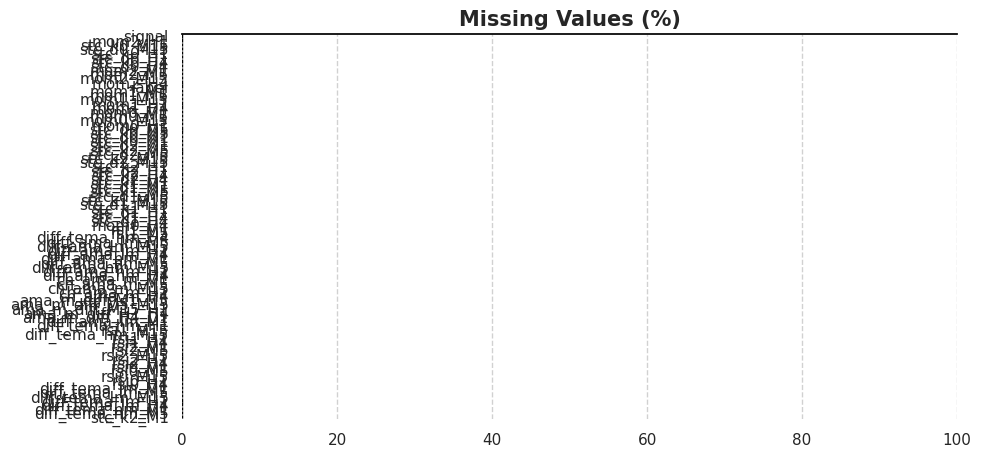

In [128]:
NaN_values = (df_tr.isnull().sum()/len(df_tr)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index,
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [129]:
df_tr[df_tr.isna().any(axis=1)]

,signal,label,ama_m_diff_H4_D1,ama_m_diff_H1_H4,ama_m_diff_M15_H1,ama_m_diff_M5_M15,ama_m_diff_M1_M5,ch_ama_m_H4,ch_ama_m_H1,ch_ama_m_M15,...,stc_d2_H4,stc_k2_H4,stc_d2_H1,stc_k2_H1,stc_d2_M15,stc_k2_M15,stc_d2_M5,stc_k2_M5,stc_d2_M1,stc_k2_M1
date_time,,,,,,,,,,,,,,,,,,,,,


In [ ]:
# def forward_fill_na(ldf):
#     # ldf['Volume_(BTC)'].fillna(0, inplace=True)
#     # ldf['Volume_(Currency)'].fillna(0, inplace=True)
#     # ldf['Weighted_Price'].fillna(0, inplace=True)
#     ldf['Open'].fillna(method='ffill', inplace=True)
#     ldf['High'].fillna(method='ffill', inplace=True)
#     ldf['Low'].fillna(method='ffill', inplace=True)
#     ldf['Close'].fillna(method='ffill', inplace=True)

# forward_fill_na(df_tr)  # modification of training set
# forward_fill_na(df_te) # modification of test set


In [130]:
df = df.drop_duplicates(keep=False,inplace=True)
df_tr = df_tr.dropna()
df_te = df_te.dropna()     # replicate on test set

In [131]:
set_option('display.precision',5)
df_tr.describe()

,signal,label,ama_m_diff_H4_D1,ama_m_diff_H1_H4,ama_m_diff_M15_H1,ama_m_diff_M5_M15,ama_m_diff_M1_M5,ch_ama_m_H4,ch_ama_m_H1,ch_ama_m_M15,...,stc_d2_H4,stc_k2_H4,stc_d2_H1,stc_k2_H1,stc_d2_M15,stc_k2_M15,stc_d2_M5,stc_k2_M5,stc_d2_M1,stc_k2_M1
count,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.0000,8000.0000,8000.00000,...,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000
mean,21.01187,-0.04637,-1038.92100,-315.88025,-191.27963,-27.63113,-7.07125,-64.2045,-24.8750,-8.11388,...,33.45050,33.06475,39.65000,38.99150,44.97062,45.51000,50.03375,50.56725,49.56963,49.42200
std,12.05577,0.97895,877.44167,247.00046,198.06839,151.01647,91.05241,67.1946,45.2783,27.50881,...,18.24251,19.68335,21.56118,23.08221,25.09720,26.50274,25.45962,26.54541,25.73449,26.48774
min,11.00000,-1.00000,-2854.00000,-895.00000,-895.00000,-638.00000,-427.00000,-309.0000,-202.0000,-272.00000,...,10.00000,8.00000,7.00000,4.00000,5.00000,3.00000,2.00000,0.00000,2.00000,0.00000
25%,12.00000,-1.00000,-1790.00000,-474.00000,-306.00000,-99.00000,-60.00000,-121.0000,-29.0000,-12.00000,...,21.00000,19.00000,20.00000,18.00000,22.00000,21.00000,27.00000,27.00000,27.00000,27.00000
50%,13.00000,-1.00000,-606.00000,-339.00000,-168.00000,-19.00000,-5.00000,-39.0000,-9.0000,0.00000,...,29.00000,31.00000,37.00000,37.00000,44.00000,45.00000,51.00000,52.00000,50.00000,49.00000
75%,23.00000,1.00000,-274.00000,-179.00000,-36.00000,55.00000,46.00000,-6.0000,0.0000,2.00000,...,43.00000,43.00000,57.00000,57.00000,66.00000,68.00000,73.00000,75.00000,72.00000,73.00000
max,61.00000,1.00000,50.00000,116.00000,210.00000,486.00000,324.00000,9.0000,42.0000,90.00000,...,73.00000,83.00000,92.00000,95.00000,94.00000,97.00000,96.00000,99.00000,97.00000,99.00000


In [107]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8000 entries, 2015-01-07 12:00:26.802000046 to 2015-01-20 13:15:48
Data columns (total 92 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   signal             8000 non-null   int8 
 1   label              8000 non-null   int8 
 2   ama_m_diff_H4_D1   8000 non-null   int16
 3   ama_m_diff_H1_H4   8000 non-null   int16
 4   ama_m_diff_M15_H1  8000 non-null   int16
 5   ama_m_diff_M5_M15  8000 non-null   int16
 6   ama_m_diff_M1_M5   8000 non-null   int16
 7   ch_ama_m_H4        8000 non-null   int16
 8   ch_ama_m_H1        8000 non-null   int16
 9   ch_ama_m_M15       8000 non-null   int16
 10  ch_ama_m_M5        8000 non-null   int16
 11  ch_ama_m_M1        8000 non-null   int16
 12  diff_ama_hm_H4     8000 non-null   int16
 13  diff_ama_hm_H1     8000 non-null   int16
 14  diff_ama_hm_M15    8000 non-null   int16
 15  diff_ama_hm_M5     8000 non-null   int16
 16  diff_ama_hm_M1

In [132]:
df_tr

,signal,label,ama_m_diff_H4_D1,ama_m_diff_H1_H4,ama_m_diff_M15_H1,ama_m_diff_M5_M15,ama_m_diff_M1_M5,ch_ama_m_H4,ch_ama_m_H1,ch_ama_m_M15,...,stc_d2_H4,stc_k2_H4,stc_d2_H1,stc_k2_H1,stc_d2_M15,stc_k2_M15,stc_d2_M5,stc_k2_M5,stc_d2_M1,stc_k2_M1
date_time,,,,,,,,,,,,,,,,,,,,,
2015-01-07 12:00:26.802000046,12,1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:00:28.628999949,21,1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:00:51.471999884,31,-1,-2671,-62,-256,-59,-76,-71,-14,-4,...,15,13,24,23,26,16,11,8,14,11
2015-01-07 12:01:00.665999889,12,-1,-2671,-62,-256,-59,-72,-71,-14,-4,...,15,13,24,23,26,16,11,8,18,22
2015-01-07 12:01:01.665999889,13,-1,-2671,-62,-256,-59,-72,-71,-14,-4,...,15,13,24,23,26,16,11,8,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-20 13:12:26.000000000,32,-1,-274,-199,-74,94,-25,-27,0,16,...,56,63,50,66,78,83,58,44,5,4
2015-01-20 13:12:38.000000000,43,-1,-274,-199,-74,94,-25,-27,0,16,...,56,63,50,66,78,83,58,44,5,4
2015-01-20 13:13:36.000000000,32,-1,-274,-199,-74,94,-38,-27,0,16,...,56,63,50,66,78,83,58,44,5,6


In [133]:
plot_vsubplots(df_tr,['ch_ama_m_M1','label'],
               title='Weighted Price & Signal Fluctional in Training Data',
               nplots=2,
               lw_id=[2,0.4],
               size=[500,1000])

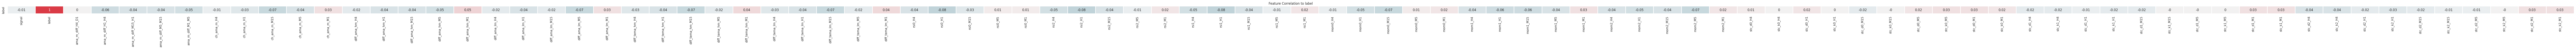

In [138]:
corrMat(df_tr,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

In [ ]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39895 entries, 2022.11.30 23:58 to 2023.01.11 02:50
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    39895 non-null  float64
 1   High    39895 non-null  float64
 2   Low     39895 non-null  float64
 3   Close   39895 non-null  float64
 4   Volume  39895 non-null  float64
 5   mom0    39895 non-null  float64
 6   mom1    39895 non-null  float64
 7   mom2    39895 non-null  float64
 8   rsi0    39895 non-null  float64
 9   rsi1    39895 non-null  float64
 10  rsi2    39895 non-null  float64
 11  sth0k   39895 non-null  float64
 12  sth1k   39895 non-null  float64
 13  sth2k   39895 non-null  float64
 14  sth0d   39895 non-null  float64
 15  sth1d   39895 non-null  float64
 16  sth2d   39895 non-null  float64
 17  ema0    39895 non-null  float64
 18  ema1    39895 non-null  float64
 19  ema2    39895 non-null  float64
 20  tema0   39895 non-null  float64
 21  tema1   39895 

In [ ]:
# df_tr = df_tr.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'ama0_1h', 'ama0_15', 'ama0_5',
#                             'bb_ama0_1h0', 'bb_ama0_1h1', 'bb_ama0_1h2', 'bb_ama0_1h3', 'bb_ama0_1h4',
#                             'bb_ama0_15m0', 'bb_ama0_15m1', 'bb_ama0_15m2', 'bb_ama0_15m3', 'bb_ama0_15m4',
#                             'bb_ama0_5m1', 'bb_ama0_5m2', 'bb_ama0_5m3', 'bb_ama0_5m4',
#                             'bb_ama1_1h0', 'bb_ama1_1h1', 'bb_ama1_1h2', 'bb_ama1_1h3', 'bb_ama1_1h4',
#                             'bb_ama1_15m0', 'bb_ama1_15m1', 'bb_ama1_15m2', 'bb_ama1_15m3', 'bb_ama1_15m4',
#                             'bb_ama1_5m1', 'bb_ama1_5m2', 'bb_ama1_5m3', 'bb_ama1_5m4',
#                             'bb_ama2_1h0', 'bb_ama2_1h1', 'bb_ama2_1h2', 'bb_ama2_1h3', 'bb_ama2_1h4',
#                             'bb_ama2_15m0', 'bb_ama2_15m1', 'bb_ama2_15m2', 'bb_ama2_15m3', 'bb_ama2_15m4',
#                             'bb_ama2_5m1', 'bb_ama2_5m2', 'bb_ama2_5m3', 'bb_ama2_5m4',
#                             'bb_ama3_1h0', 'bb_ama3_1h1', 'bb_ama3_1h2', 'bb_ama3_1h3', 'bb_ama3_1h4',
#                             'bb_ama3_15m0', 'bb_ama3_15m1', 'bb_ama3_15m2', 'bb_ama3_15m3', 'bb_ama3_15m4',
#                             'bb_ama3_5m1', 'bb_ama3_5m2', 'bb_ama3_5m3', 'bb_ama3_5m4',
#                             'bb_tema2_1h0', 'bb_tema2_1h1', 'bb_tema2_1h2', 'bb_tema2_1h3', 'bb_tema2_1h4',
#                             'bb_tema3_1h0', 'bb_tema3_1h1', 'bb_tema3_1h2', 'bb_tema3_1h3', 'bb_tema3_1h4'])

In [135]:
models = []
# Lightweight Models
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=55)))
# models.append(('XGB',XGBClassifier(n_estimators=55,eval_metric='logloss')))
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=55)))
models.append(('RF', RandomForestClassifier(n_estimators=55)))


In [136]:
# eval_id (T/F): [CV,Train,Test,all]

def modelEval(ldf,feature='label',split_id=[None,None],eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=[False,True],cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):

    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    if(eval_id[2]):
        if(split_id[0] is not None):
            print(f'Train/Evaluation Set Spit Activated: {split_id[0]}')
        if(split_id[1] is not None):
            print(f'Train/Evaluation Set Split made at {split_id[1]}')

    ''' 1. Split Train/Evaluation <DataFrame> Set Split '''

    # split_id : Train/Test split [%,timestamp], whichever is not None
    # test_id : Evaluate trained model on test set only

    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,eval_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; eval_df = df.loc[split_id[1]:]
    else:
        print('Choose One Splitting Method Only')

    ''' 2. Train/Test Feature Matrices + Target Variables Split'''

    y_train = train_df[feature]
    X_train = train_df.loc[:, train_df.columns != feature]
    y_eval = eval_df[feature]
    X_eval = eval_df.loc[:, eval_df.columns != feature]
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)

    print('');print(f'Using Features: {X_train.columns}')
    print(f'Target Variable: {feature}');print('')

    ''' 3. Visualise Training/Test Data'''
    if(plot_id[0]):

        # plot the training data
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df['signal'],mode='lines',name='Training Data', line={'width': 0.25}))
        fig.update_layout(height=300,width=800,template='plotly_white',title='Training Signal Visualisation',
                          margin=dict(l=50,r=80,t=50,b=40))

        # Plot the test data as well
        if(eval_id[2]):
            fig.add_trace(go.Scatter(x=eval_df.index, y=eval_df['signal'],mode='lines',name='Test Data',line={'width': 0.25}))
            fig.update_layout(title='Training/Test Signal Visualisation')
        fig.show()

    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            print(name)

            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation

            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_eval),y_eval); lst_eval.append(eval_res)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction

            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe

            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")

    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])

    ''' 5. Visual Ouputs '''
    if(plot_id[1]):

        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)

        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['signal', 'ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'ch_ama_m_M1', 'diff_ama_hm_H4',
       'diff_ama_hm_H1', 'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1',
       'diff_ama_lm_H4', 'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5',
       'diff_ama_lm_M1', 'diff_tema_hm_H4', 'diff_tema_hm_H1',
       'diff_tema_hm_M15', 'diff_tema_hm_M5', 'diff_tema_hm_M1',
       'diff_tema_lm_H4', 'diff_tema_lm_H1', 'diff_tema_lm_M15',
       'diff_tema_lm_M5', 'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15',
       'rsi0_M5', 'rsi0_M1', 'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5',
       'rsi2_M1', 'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5', 'rsi1_M1',
       'mom0_H4', 'mom0_H1', 'mom0_M15', 'mom0_M

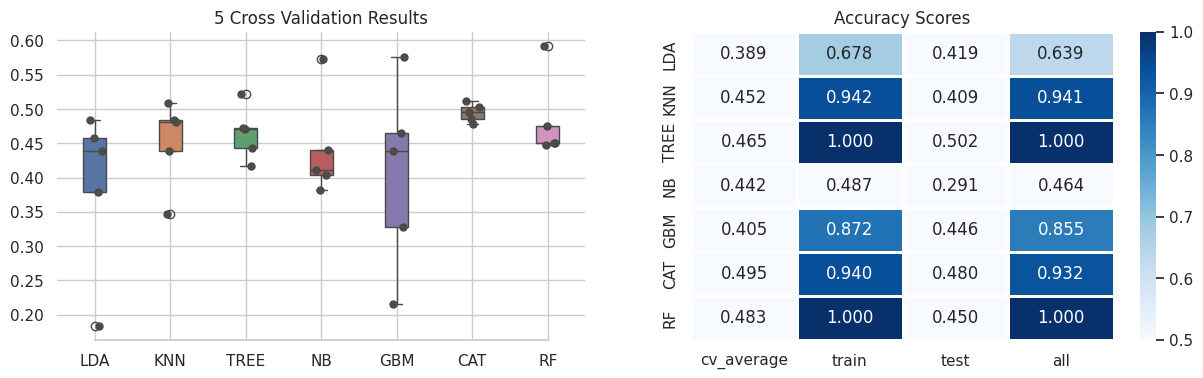

In [117]:
modelEval(df_tr,split_id=[0.2,None],plot_id=[False,True])

In [ ]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39895 entries, 2022.11.30 23:58 to 2023.01.11 02:50
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    39895 non-null  float64
 1   High    39895 non-null  float64
 2   Low     39895 non-null  float64
 3   Close   39895 non-null  float64
 4   Volume  39895 non-null  float64
 5   mom0    39895 non-null  float64
 6   mom1    39895 non-null  float64
 7   mom2    39895 non-null  float64
 8   rsi0    39895 non-null  float64
 9   rsi1    39895 non-null  float64
 10  rsi2    39895 non-null  float64
 11  sth0k   39895 non-null  float64
 12  sth1k   39895 non-null  float64
 13  sth2k   39895 non-null  float64
 14  sth0d   39895 non-null  float64
 15  sth1d   39895 non-null  float64
 16  sth2d   39895 non-null  float64
 17  ema0    39895 non-null  float64
 18  ema1    39895 non-null  float64
 19  ema2    39895 non-null  float64
 20  tema0   39895 non-null  float64
 21  tema1   39895 

In [ ]:
df_tr = df_tr.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'ema0', 'ema1', 'ema2', 'tema0', 'tema1', 'tema2', 'ama0', 'ama1', 'ama2'])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['signal', 'ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'ch_ama_m_M1', 'diff_ama_hm_H4',
       'diff_ama_hm_H1', 'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1',
       'diff_ama_lm_H4', 'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5',
       'diff_ama_lm_M1', 'diff_tema_hm_H4', 'diff_tema_hm_H1',
       'diff_tema_hm_M15', 'diff_tema_hm_M5', 'diff_tema_hm_M1',
       'diff_tema_lm_H4', 'diff_tema_lm_H1', 'diff_tema_lm_M15',
       'diff_tema_lm_M5', 'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15',
       'rsi0_M5', 'rsi0_M1', 'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5',
       'rsi2_M1', 'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5', 'rsi1_M1',
       'mom0_H4', 'mom0_H1', 'mom0_M15', 'mom0_M

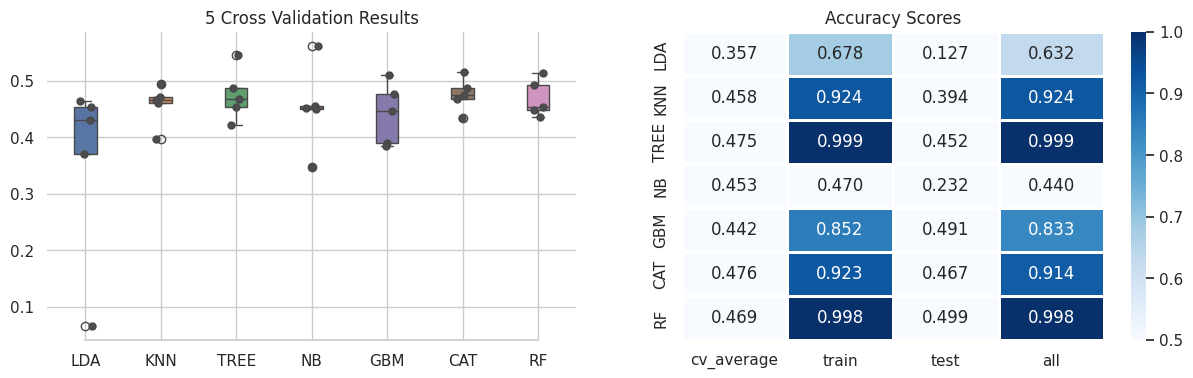

In [137]:
# на передостанньому (останній сформований)
modelEval(df_tr,split_id=[0.2,None],plot_id=[False,True])

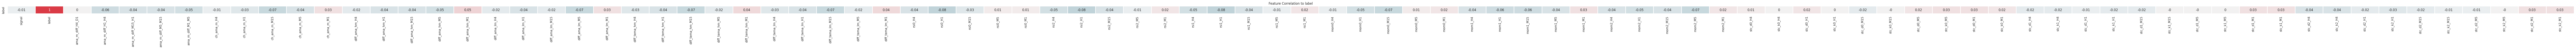

In [ ]:
corrMat(df_tr,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

In [139]:
df_tr = df_tr.drop(columns=['ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
                            'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
                            'ch_ama_m_M15', 'ch_ama_m_M5', 'diff_ama_hm_H4',
                            'diff_ama_hm_H1', 'diff_ama_hm_M15', 'diff_ama_hm_M5',
                            'diff_ama_lm_H4', 'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5',
                            'diff_tema_hm_H4', 'diff_tema_hm_H1', 'diff_tema_hm_M15', 'diff_tema_hm_M5',
                            'diff_tema_lm_H4', 'diff_tema_lm_H1', 'diff_tema_lm_M15','diff_tema_lm_M5',
                            'rsi0_H4', 'rsi0_H1', 'rsi0_M15', 'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5',
                            'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5', 'mom0_H4', 'mom0_H1', 'mom0_M15',
                            'mom1_H4', 'mom1_H1', 'mom1_M15', 'mom1_M5', 'mom2_H4', 'mom2_H1','mom2_M15',
                            'mom2_M5', 'stc_d1_H4', 'stc_k1_H4', 'stc_d1_H1', 'stc_k1_H1', 'stc_d1_M15',
                            'stc_k1_M15', 'stc_d1_M5', 'stc_k1_M5', 'stc_d2_H4', 'stc_k2_H4', 'stc_d2_H1',
                            'stc_k2_H1', 'stc_d2_M15', 'stc_k2_M15', 'stc_d2_M5', 'stc_k2_M5',])

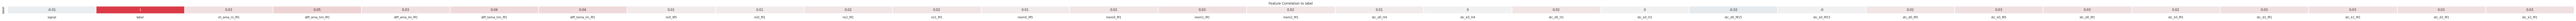

In [140]:
corrMat(df_tr,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['signal', 'ch_ama_m_M1', 'diff_ama_hm_M1', 'diff_ama_lm_M1',
       'diff_tema_hm_M1', 'diff_tema_lm_M1', 'rsi0_M5', 'rsi0_M1', 'rsi2_M1',
       'rsi1_M1', 'mom0_M5', 'mom0_M1', 'mom1_M1', 'mom2_M1', 'stc_d0_H4',
       'stc_k0_H4', 'stc_d0_H1', 'stc_k0_H1', 'stc_d0_M15', 'stc_k0_M15',
       'stc_d0_M5', 'stc_k0_M5', 'stc_d0_M1', 'stc_k0_M1', 'stc_d1_M1',
       'stc_k1_M1', 'stc_d2_M1', 'stc_k2_M1'],
      dtype='object')
Target Variable: label

LDA
LDA : 0.404(0.032) -> 0.13s | 0.532 & 0.496 -> 0.03s | 0.517 -> 0.057s
KNN
KNN : 0.437(0.017) -> 1.09s | 0.898 & 0.466 -> 1.26s | 0.894 -> 1.5s
TREE
TREE : 0.437(0.038) -> 0.42s | 0.999 & 0.458 -> 0.12s | 0.999 -> 0.13s
NB
NB : 0.457(0.065) -> 0.04s | 0.494 & 0.483 -> 0.01s | 0.491 -> 0.011s
GBM
GBM : 0.470(0.083) -> 19.72s | 0.802 & 0.482 -> 4.22s | 0.772 -> 6.1s
CAT
CAT : 0.450(0.038) -

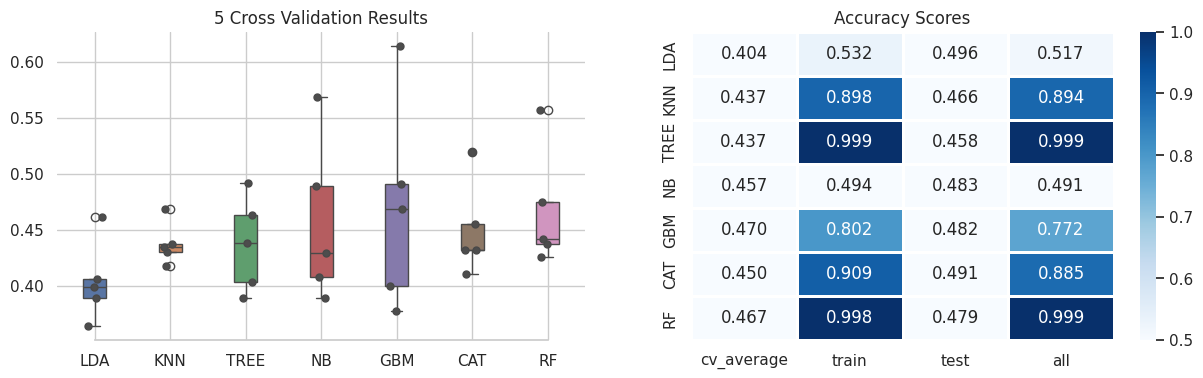

In [141]:
# на передостанньому (останній сформований)
modelEval(df_tr,split_id=[0.2,None],plot_id=[False,True])